In [1]:
from __future__ import division # to set floating point decimal
import nltk
from urllib.request import urlopen, Request # for webpages
from nltk import bigrams
import bs4
from bs4 import BeautifulSoup
import re
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import twitter, json

In [4]:
%run "D:\Daniels_Quarter3\Complex Data Analysis\Week 8\Lesson16_Homework\PrivateMyTwitterAuth.py"

In [5]:
twitter_api = twitter.Api(consumer_key=CONSUMER_KEY,
                  consumer_secret=CONSUMER_SECRET,
                  access_token_key=ACCESS_TOKEN,
                  access_token_secret=ACCESS_TOKEN_SECRET,
                  tweet_mode='extended'
                  )

In [25]:
#Searching about recently hld 2019 Indian elections
q = '#IndianElections2019' 

def get_search_results(q, search_results=None, statuses=[], n=None):
    if n is None: # treat as equivalent to exhaustively search
        
        if search_results is None: # if function is on its first run
            
            if q is not None: # if on first one search term is needed
                search_results=twitter_api.GetSearch(term=u"{}".format(q), count=20, return_json=True)#Json object but can be treated as a dict
                
                firstResults = search_results['statuses'] #A list of dictionaries 
                if len(firstResults) > 0:
                    pass
                else:
                    print("No statuses found.")
                    return []
            else:
                raise ValueError("must specify query string")
        else:
            pass
        # then try and find next set of results reported by data (the next page)
        # recall self until there are no more next_results found in metadata
        
        statuses.extend(search_results['statuses'])
        try:
            next_page_url = search_results['search_metadata']['next_results'].replace("?", "").replace("&src=typd", "")
        except KeyError as e: # No more results when next_results doesn't exist
            return statuses
        else:
            next_page_results = twitter_api.GetSearch(raw_query=next_page_url, return_json=True)
            return get_search_results(q=None, search_results=next_page_results, statuses=statuses)
    else:
        # If actual number is specified return specified results
        if q is not None:
            search_results=twitter_api.GetSearch(term=u"{}".format(q), count=n, return_json=True)
            return search_results['statuses']

rawresults=get_search_results(q=q,n=100)
#to save file
rawdata_file="temp"
json.dump(rawresults,open(rawdata_file, mode='w'))

In [26]:
#to load from file
results=json.load(open(rawdata_file, mode='r'))
resultsView=json.dumps(results,indent=2)
#print(resultsView)
#print (results[0]['full_text'])
print(len(results))

100


In [27]:
#Extracting text, screen names, and hashtags from tweets
from string import punctuation
status_texts = []
hashtags = []
scrn_names = []
words_list = []

import re
punkts = list(punctuation) 
myPunkts=["...", u"\u2026"]
punkts=punkts+myPunkts
punkts.remove("@")
punkts.remove("#")
#print(punkts) 
#your turn: why did I remove those two above?

for status in results:
    if status['lang'] == 'en':
        status_text = status['full_text']
        for p in punkts:
            status_text=status_text.replace(p,"")
        word_list = [w.lower() for w in status_text.split() if w.find("#") == -1 and w.find("@") == -1 and w.find("http")== -1 and w.find("https")== -1]
        words_list.extend(word_list)  # Compute a collection of all words from all tweets
        screen_name = [user_mention['screen_name'] for user_mention in status['entities']['user_mentions'] ]
        hashtag = [ hashtag['text'] for hashtag in status['entities']['hashtags'] ]

        status_texts.append(status_text)
        scrn_names.extend(screen_name)
        hashtags.extend(hashtag)
       
    else: pass

#print(status_texts)
#print(hashtags)
#print(words_list)

In [28]:
x='\n'.join(map(str, words_list))
tokenstweets = nltk.word_tokenize(x) # Create tokens (just looks for spaces in between "words")
print(type(tokenstweets)) # now we have a list of words
print(len(tokenstweets)) # we see we have 1494 tokens
print (tokenstweets[:10])

<class 'list'>
1493
['congratulations', 'on', 'a', 'remarkable', 'win', 'in', 'your', 'continued', 'commitment', 'to']


In [29]:
textTweets = nltk.Text(tokenstweets)

# Let’s get rid of some stop words 
stopwords = nltk.corpus.stopwords.words('english')
customstopwords =["news","NBC","Saturday","Sunday","May","said","n't","seasons","users","I","It","TV", "review", "reviews", "critic", "season", "episode","All","full","Critic","Reviews","Season","Game","Thrones","read","Read",'New','new','the',"The","Show","show","Shows","shows","Series","series"]

punc = ['?','”',',','.','&','$','*',';','{','}','[',']','(',')','=','!','`','','>','+','<',':',"'s",'\’','...', '…','“','©','#','-',"\'",'!-!','—','!.!','»',"'"]
textTweets = [w for w in textTweets if w not in punc]
textTweets = [w for w in textTweets if w not in stopwords]
textTweets = [w for w in textTweets if w not in customstopwords]
textTweets = [re.sub(r'\d+', '!', str(w)) for w in textTweets if 1 == 1]
textTweets = [re.sub(r'\|+', '', str(w)) for w in textTweets if 1 == 1]
textTweets = [w for w in textTweets if w not in ['!']]

#print(textTweets)

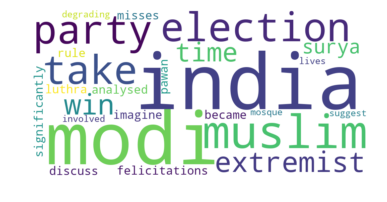

In [30]:
stopwords = set(STOPWORDS)
stopwords.update(["\'"],"news","NBC","Saturday","Sunday","May","Photo","said","Said","india","heats","debate")

x='\n'.join(map(str, list(set(textTweets))))

# Generate a word cloud image for the Critics Reviews for the top 25 words
wordcloud = WordCloud(max_words=25,width=1000,height=500,background_color="white",stopwords = stopwords).generate(x)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
# Save the image in the img folder:
wordcloud.to_file("Indian_Elections_2019.png")